In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
dataset_folder = "../../dataset/"

# Microsoft

In [3]:
microsoft_df = pd.read_csv(dataset_folder + "Microsoft_Stock.csv")

In [4]:
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(microsoft_df.values.reshape(-1,1))
scaled

array([[0.00210064],
       [0.        ],
       [0.00615535],
       ...,
       [0.95236932],
       [0.9358085 ],
       [0.95495848]])

In [7]:
# X_train = []
# y_train = []
# for i in range(60, 1151):
#     X_train.append(train_scaled[i-60:i, 0])
#     y_train.append(train_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train

In [8]:
# y_train

In [9]:
def split_data(stock, lookback):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1185, 30, 1)
y_train.shape:  (1185, 1)
X_test.shape:  (296, 30, 1)
y_test.shape:  (296, 1)


In [10]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers, drop_prob=0.2):
        super(RNN, self).__init__()
        
        #Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining layers
        #RNN
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #activation function
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self,batch_size):
        #generates the first hidden state of zeros used in the forward pass
        #we'll send the tensor holding the hidden state to the device we specified earlier as well 
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="RNN"):
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):

        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            
            loss = criterion(out, label.float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        #print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        #epoch_times.append(current_time-start_time)
    #print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        h = model.init_hidden(1)
        avg_loss = 0.
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values

In [12]:
lr = 0.001
rnn_model = train(train_loader, lr, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.017544900309682514
Epoch 2/5 Done, Total Loss: 0.0036273344942148672
Epoch 3/5 Done, Total Loss: 0.0005788996697649256
Epoch 4/5 Done, Total Loss: 0.0001548211787141756
Epoch 5/5 Done, Total Loss: 9.189553808634325e-05


In [13]:
predictions, values = evaluate(rnn_model,test_loader)

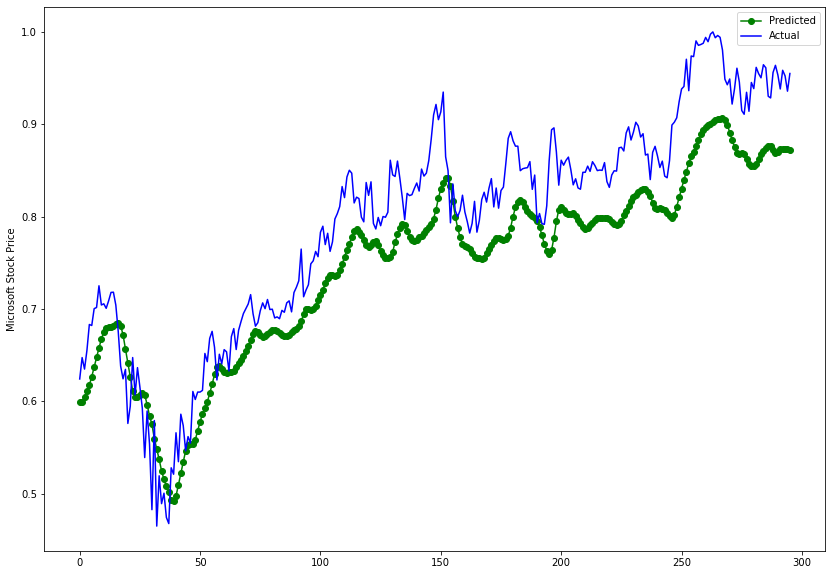

In [14]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

## Artificial Data

In [15]:
art_data = pd.read_csv(dataset_folder +"Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [16]:
lookback = 30 # choose sequence length
train_x,train_y,test_x,test_y = split_data(art_data, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5822, 30, 1)
y_train.shape:  (5822, 1)
X_test.shape:  (1455, 30, 1)
y_test.shape:  (1455, 1)


In [17]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [18]:
lr = 0.001
rnn_model = train(train_loader, lr, model_type="RNN")

Starting Training of RNN model


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/5 Done, Total Loss: 0.0014282599363974037
Epoch 2/5 Done, Total Loss: 3.229369257395673e-05
Epoch 3/5 Done, Total Loss: 2.65997482832366e-05
Epoch 4/5 Done, Total Loss: 2.547455636279968e-05
Epoch 5/5 Done, Total Loss: 3.048914069141675e-05


In [19]:
predictions, values = evaluate(rnn_model,test_loader)

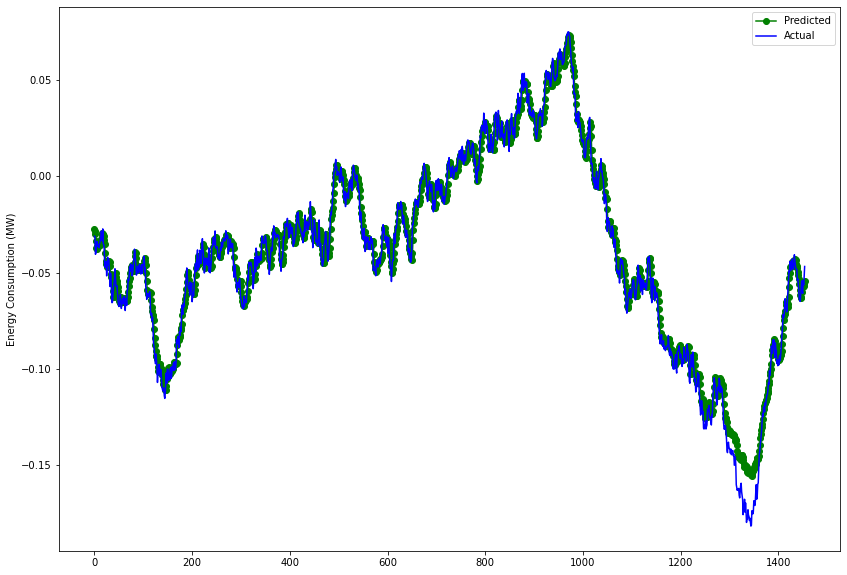

In [20]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

## 